In [1]:
# 原文连接：https://tensorflow.google.cn/tutorials/eager/custom_training_walkthrough?hl=zh-cn

In [2]:
# 代码自动完成
%config IPCompleter.greedy=True

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.VERSION

'1.10.0'

#### 启用Eager Execution环境

In [4]:
# tf.enable_eager_execution()
tf.contrib.eager.enable_eager_execution()

下载数据集

In [5]:
train_dataset_rul='http://download.tensorflow.org/data/iris_training.csv'
fname=os.path.basename(train_dataset_rul)
origin=train_dataset_rul
train_dataset_fp=tf.keras.utils.get_file(fname=fname,origin=origin)
print('local copy of the dataset file:{}',format(train_dataset_fp))

local copy of the dataset file:{} C:\Users\Administrator\.keras\datasets\iris_training.csv


In [6]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [7]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [8]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

#### 创建一个Dataset

由于数据集是 CSV 格式的文本文件，请使用 `make_csv_dataset` 函数将数据解析为合适的格式

默认行为是对数据进行随机处理`shuffle=true`

In [9]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

`make_csv_dataset` 函数返回 (features, label) 对的 `tf.data.Dataset`，

其中 features 是一个字典：{'feature_name': value}

In [10]:
features, labels = next(iter(train_dataset))

# features

In [11]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [12]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    l=list(features.values())
#     print(l)
#   将多个数据，进行组合。axis=1,按列进行组合。
    features = tf.stack(l, axis=1)
#     print(features)
#     print(tf.transpose(features))
    return features, labels

打包到训练数据集中

In [13]:
train_dataset=train_dataset.map(pack_features_vector)

查看数据样本

In [14]:
features,labels=next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[7.7 2.6 6.9 2.3]
 [4.6 3.2 1.4 0.2]
 [7.2 3.  5.8 1.6]
 [5.6 2.7 4.2 1.3]
 [4.4 3.2 1.3 0.2]], shape=(5, 4), dtype=float32)


### 选择模型类型

为何要使用模型？
- __模型__是指__特征__与__标签__之间的__关系__
- 传统编程技巧使用大量条件语句创建模型
- 简单的模型可以是几行代数进行描述，复杂的机器学习模型拥有大量难以汇总的参数
- 一个好的机器学习方法可以确定好的模型
- 只需要将足够多的代表性样本馈送到正确类型的机器学习__模型__中，该程序便会找找出与__标签__相应的关系

### 用keras创建模型

In [15]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10,activation=tf.nn.relu,input_shape=(4,)),
        tf.keras.layers.Dense(10,activation=tf.nn.relu),
        tf.keras.layers.Dense(3)
    ]
)

每个样本针对每个类别返回一个__对数__

In [16]:
prediction=model(features)
h5=prediction[:5]
h5

<tf.Tensor: id=203, shape=(5, 3), dtype=float32, numpy=
array([[ 0.33358592, -1.9791582 , -0.15004939],
       [ 0.3743457 ,  0.19900483, -0.7938784 ],
       [ 0.42144403, -1.3854866 , -0.40658963],
       [ 0.40736535, -0.91604483, -0.47283232],
       [ 0.3610692 ,  0.20879689, -0.7795994 ]], dtype=float32)>

将这__对数__转换为每个类别的概率

In [17]:
tf.nn.softmax(h5)

<tf.Tensor: id=205, shape=(5, 3), dtype=float32, numpy=
array([[0.58291113, 0.05770193, 0.35938686],
       [0.46509692, 0.3902958 , 0.14460729],
       [0.6245844 , 0.10253003, 0.27288562],
       [0.5949099 , 0.1583804 , 0.2467097 ],
       [0.459061  , 0.39422065, 0.14671831]], dtype=float32)>

对每个类别执行 `tf.argmax` 运算可得出预测的__类别索引__

In [18]:
print("Prediction: {}".format(tf.argmax(prediction, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [2 0 2 1 0 2 0 2 2 1 0 2 0 2 0 2 1 0 0 2 2 2 1 2 0 0 0 1 1 1 2 2]


### 训练模型
在此阶段中，模型会逐渐得到优化，也就是说，模型会了解数据集。

目标是充分了解训练数据集的结构，以便对未见过的数据进行预测。


### 定义损失和梯度函数
在训练和评估阶段，我们需要计算__模型的损失__。

这样可以__衡量__模型的__预测结果__与__预期标签__有多大__偏差__，也就是说，模型的效果有多差

我们希望尽可能__减小或优化__这个__偏差值__。

In [19]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.2269155979156494


使用 `tf.GradientTape` context 计算用于优化模型的梯度

In [20]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

设置优化器和训练用的计数器

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

单个优化步骤

In [22]:
# 得到损失值和微分结果
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

# 优化器应用上个骤得到的微分结果来更新模型的权重与偏置变量值
optimizer.apply_gradients(zip(grads, model.variables), global_step)
# 计算损失值
loss_value = loss(model, features, labels)
print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

Step: 0, Initial Loss: 1.2269155979156494
Step: 1,         Loss: 1.1540448665618896


## 训练循环

In [23]:
train_loss_results=[]
train_accuracy_results=[]

num_epochs=200

for epoch in range(num_epochs):
    epoch_loss_avg=tfe.metrics.Mean()
    epoch_accuracy=tfe.metrics.Accuracy()
    
    for x,y in train_dataset:
       loss_value,grads=grad(model,x,y)
       optimizer.apply_gradients(zip(grads,model.variables))
       
       epoch_loss_avg(loss_value)
       epoch_accuracy(tf.argmax(model(x),axis=1,output_type=tf.int32),y)
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result()) 
    
#     if epoch % 50 == 0:
#         print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
#                                                                 epoch_loss_avg.result(),
#                                                                 epoch_accuracy.result()))
    if epoch %50 == 0:
        print("e:{:03d},loss:{:.3f},accuracy:{:.3%}".format(epoch,train_loss_results[-1],train_accuracy_results[-1]))
       
            

e:000,loss:1.143,accuracy:41.667%
e:050,loss:0.386,accuracy:91.667%
e:100,loss:0.257,accuracy:94.167%
e:150,loss:0.188,accuracy:97.500%


In [24]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

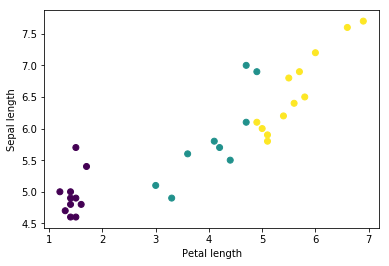

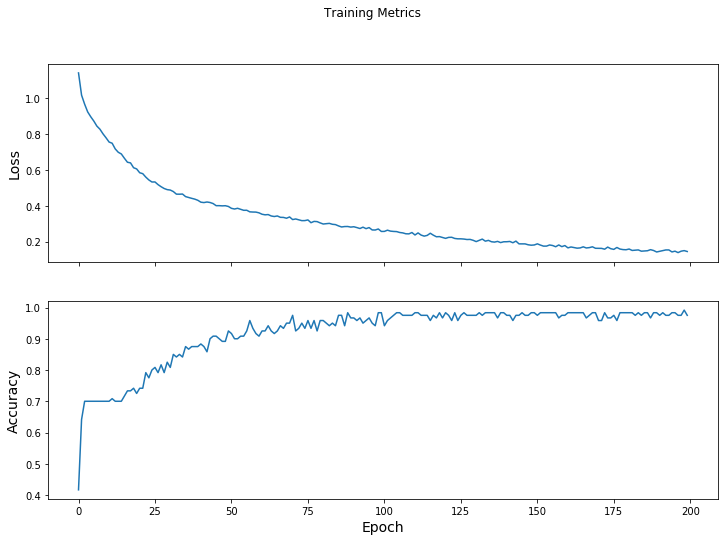

In [25]:
plt.show()

## 评估模型的效果

#### 设置测试数据集

In [27]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [28]:
test_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

#### 评估模型

In [29]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 94.167%


## 使用经过训练的模型进行预测

In [30]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.2%)
Example 1 prediction: Iris versicolor (95.0%)
Example 2 prediction: Iris virginica (53.2%)
